# Auto Encoder

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm_notebook
import  matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix , accuracy_score, plot_confusion_matrix, ConfusionMatrixDisplay

np.random.seed(1234)

In [0]:
# choose GPU/CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [0]:
import torchvision
fmnist_train = torchvision.datasets.FashionMNIST('/content/', download=True)
fmnist_test  = torchvision.datasets.FashionMNIST('/content/', download=True, train=False)

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...
Done!


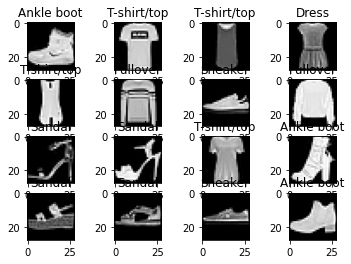

In [0]:
for i in range(16):
    f, t = fmnist_train[i]
    plt.subplot(4, 4, i+1)
    plt.imshow(f, cmap='gray')
    plt.title(fmnist_train.classes[t])

In [0]:
class FMNIST_DS(Dataset):
    def __init__(self, ds):
        super().__init__()
        self.ds = ds
        self.len = len(ds)

    def __getitem__(self, index):
        image , target = self.ds[index] 

        feature = np.array(image).flatten()/256.0
        feature = torch.tensor(feature , dtype=torch.float)

        target  = torch.tensor(target)
        
        return  feature, target
       
    def __len__(self):
        return self.len

class ENCODE_DS(Dataset):
    def __init__(self, ds):
        super().__init__()
        self.ds = ds
        self.len = len(ds)

    def __getitem__(self, index):
        image , target = self.ds[index] 

        feature = np.array(image).flatten()/256.0
        feature = torch.tensor(feature , dtype=torch.float)
        
        return  feature, feature
       
    def __len__(self):
        return self.len


In [0]:
train_ds = ENCODE_DS(fmnist_train)
test_ds  = ENCODE_DS(fmnist_test)

In [0]:
f , t = next(iter(train_ds))
f.shape , t.shape

(torch.Size([784]), torch.Size([784]))

In [0]:
batch_size = 256
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 1)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(train_dl))
fs.shape , ts.shape

(torch.Size([100, 784]), torch.Size([100, 784]))

In [0]:
class MLP0(nn.Module):
    def __init__(self, input_dim = 200 , output_dim = 10):
        super().__init__()
        self.n = input_dim
        self.o = output_dim

        self.fc1  = nn.Linear(self.n, self.o)
        self.act1 = nn.Tanh()

    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)

        return out

class ENCODER(nn.Module):
    def __init__(self, input_dim = 784, hidden1 = 500, hidden2 = 300, output_dim = 200):
        super().__init__()
        self.n = input_dim
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.o = output_dim

        # encode
        self.fc1  = nn.Linear(self.n, self.hidden1)
        self.act1 = nn.Tanh()
        self.fc2  = nn.Linear(self.hidden1, self.hidden2)
        self.act2 = nn.Tanh()
        self.fc3  = nn.Linear(self.hidden2, self.o)
        self.act3 = nn.Tanh()

        #decode
        self.fc4  = nn.Linear(self.o, self.hidden2)
        self.act4 = nn.Tanh()
        self.fc5  = nn.Linear(self.hidden2, self.hidden1)
        self.act5 = nn.Tanh()
        self.fc6  = nn.Linear(self.hidden1, self.n)
        self.act6 = nn.Tanh()

    def encode(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        out = self.fc3(out)
        out = self.act3(out)
        return out

    def decode(self, x):
        out = self.fc4(x)
        out = self.act4(out)
        out = self.fc5(out)
        out = self.act5(out)
        out = self.fc6(out)
        out = self.act6(out)
        return out


    def forward(self, x):
        #encode
        out = self.encode(x)
        #decode
        out = self.decode(out)
        return out
    

In [0]:
encoder = ENCODER().to(device)

In [0]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(net.parameters(),lr=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.999)

In [0]:
def plt_conf_mat(y_true , y_pred, labels, normalize = 'true'  , include_values = True, 
                 xticks_rotation='horizontal',
                 values_format=None,
                 cmap='winter'):
    plt.figure(figsize=[9, 9])
    ax = plt.subplot(1, 1, 1)
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

In [0]:
def train_step(model, train_dl, criterion, optimizer):
    total_loss = 0.0
    total_correct = 0
    
    # for i, (train_inputs, train_labels) in tqdm_notebook(enumerate(train_dl), 
    #                                                      desc='Training', 
    #                                                      total=len(train_dl)):
    for i, (train_inputs, train_labels) in enumerate(train_dl):
        # move to device
        train_inputs , train_labels = train_inputs.to(device) , train_labels.to(device)

        optimizer.zero_grad()
        output = model(train_inputs)
        loss = criterion(output, train_labels)
        loss.backward()     
        optimizer.step()
        total_loss += loss.item()
        # with torch.no_grad():
        #     mx , argmx = torch.max(output, dim=1)
        #     total_correct += torch.sum(argmx == train_labels).item()/len(argmx)

    return total_loss/len(train_dl), total_correct/len(train_dl)


def validate_step(model, valid_dl, criterion):
    total_loss = 0.0
    total_correct = 0
    with torch.no_grad():
        # for i, (test_inputs, test_labels) in tqdm_notebook(enumerate(valid_dl), 
        #                                                 desc='Validation', 
        #                                                 total=len(valid_dl)):
        for i, (test_inputs, test_labels) in enumerate(valid_dl):
            # move to device
            test_inputs , test_labels = test_inputs.to(device) , test_labels.to(device)

            output = model(test_inputs)
            loss = criterion(output, test_labels)
            total_loss += loss.item()

            # mx , argmx = torch.max(output, dim=1)
            # total_correct += torch.sum(argmx == test_labels).item()/len(argmx)

    return total_loss/len(test_dl), total_correct/len(test_dl)


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs, train_loss, test_loss, train_acc, test_acc):
    
    best_wts = None
    best_loss = float('inf')

    for epoch in range(num_epochs):

        ## perform one epoch of training and validation
        trn_loss, trn_acc = train_step(model, train_dl, criterion, optimizer)
        val_loss, val_acc = validate_step(model, valid_dl, criterion)
        scheduler.step()

        train_loss += [trn_loss]
        test_loss  += [val_loss]
        train_acc  += [trn_acc ]
        test_acc   += [val_acc ]

        # save weights
        if val_loss < best_loss:
            best_loss = val_loss
            best_wts = model.state_dict().copy()
            
# #             torch.save(best_wts, 'models/lstm-{}-{}-{}-{}-{}-{}-{:.5f}.pth'.format(
# #                 epoch, max_len, min_count, model.embed_size, model.hidden_size, model.num_layers, best_acc))

        print(f'[Epoch:{epoch+1}/{num_epochs}] Training Loss: %.4f| Testing Loss: %.4f| Training ACC: %.4f| Testing ACC: %.4f|'
              % (trn_loss* 10000, val_loss* 10000 , trn_acc*100, val_acc*100))

    model.load_state_dict(best_wts)
    return train_loss, test_loss, train_acc, test_acc

In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(encoder, train_dl, test_dl, criterion, optimizer, scheduler, 100, train_loss, test_loss, train_acc, test_acc)

[Epoch:1/100] Training Loss: 137.1034| Testing Loss: 138.8043| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:2/100] Training Loss: 137.0878| Testing Loss: 138.7752| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:3/100] Training Loss: 137.0934| Testing Loss: 138.7568| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:4/100] Training Loss: 137.0262| Testing Loss: 138.7177| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:5/100] Training Loss: 137.0143| Testing Loss: 138.6927| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:6/100] Training Loss: 136.9866| Testing Loss: 138.6593| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:7/100] Training Loss: 136.9575| Testing Loss: 138.6276| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:8/100] Training Loss: 136.9021| Testing Loss: 138.5962| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:9/100] Training Loss: 136.8780| Testing Loss: 138.5753| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:10/100] Training Loss: 136.8675| Testin

Text(0.5, 1.0, 'trianing loss: 1000, 100')

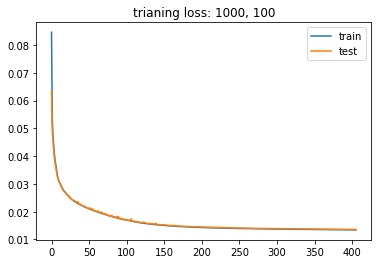

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss: 1000, 100')

In [0]:
# load saved encoder
encoder.load_state_dict(torch.load('/content/drive/My Drive/ut/NNDL/encoder.pth'))

<All keys matched successfully>

In [0]:
net2 = MLP0().to(device)

In [0]:
train_ds = FMNIST_DS(fmnist_train)
test_ds  = FMNIST_DS(fmnist_test)
batch_size = 256
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 10)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 10)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net2.parameters(),lr=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [0]:
def train_step(model, train_dl, criterion, optimizer, encoder):
    total_loss = 0.0
    total_correct = 0
    
    # for i, (train_inputs, train_labels) in tqdm_notebook(enumerate(train_dl), 
    #                                                      desc='Training', 
    #                                                      total=len(train_dl)):
    for i, (train_inputs, train_labels) in enumerate(train_dl):
        # move to device
        train_inputs , train_labels = train_inputs.to(device) , train_labels.to(device)

        optimizer.zero_grad()
        train_inputs = encoder.encode(train_inputs)
        output = model(train_inputs)
        loss = criterion(output, train_labels)
        loss.backward()     
        optimizer.step()
        total_loss += loss.item()
        with torch.no_grad():
            mx , argmx = torch.max(output, dim=1)
            total_correct += torch.sum(argmx == train_labels).item()/len(argmx)

    return total_loss/len(train_dl), total_correct/len(train_dl)


def validate_step(model, valid_dl, criterion, encoder):
    total_loss = 0.0
    total_correct = 0
    with torch.no_grad():
        # for i, (test_inputs, test_labels) in tqdm_notebook(enumerate(valid_dl), 
        #                                                 desc='Validation', 
        #                                                 total=len(valid_dl)):
        for i, (test_inputs, test_labels) in enumerate(valid_dl):
            # move to device
            test_inputs , test_labels = test_inputs.to(device) , test_labels.to(device)
            test_inputs = encoder.encode(test_inputs)
            output = model(test_inputs)
            loss = criterion(output, test_labels)
            total_loss += loss.item()

            mx , argmx = torch.max(output, dim=1)
            total_correct += torch.sum(argmx == test_labels).item()/len(argmx)

    return total_loss/len(test_dl), total_correct/len(test_dl)


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler, encoder, num_epochs, train_loss, test_loss, train_acc, test_acc):
    
    best_wts = None
    best_loss = float('inf')

    for epoch in range(num_epochs):

        ## perform one epoch of training and validation
        trn_loss, trn_acc = train_step(model, train_dl, criterion, optimizer, encoder)
        val_loss, val_acc = validate_step(model, valid_dl, criterion, encoder)
        scheduler.step()

        train_loss += [trn_loss]
        test_loss  += [val_loss]
        train_acc  += [trn_acc ]
        test_acc   += [val_acc ]

        # save weights
        if val_loss < best_loss:
            best_loss = val_loss
            best_wts = model.state_dict().copy()
            
# #             torch.save(best_wts, 'models/lstm-{}-{}-{}-{}-{}-{}-{:.5f}.pth'.format(
# #                 epoch, max_len, min_count, model.embed_size, model.hidden_size, model.num_layers, best_acc))

        print(f'[Epoch:{epoch+1}/{num_epochs}] Training Loss: %.4f| Testing Loss: %.4f| Training ACC: %.4f| Testing ACC: %.4f|'
              % (trn_loss* 10000, val_loss* 10000 , trn_acc*100, val_acc*100))

    model.load_state_dict(best_wts)
    return train_loss, test_loss, train_acc, test_acc

In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(net2, train_dl, test_dl, criterion, optimizer, scheduler, encoder, 100, train_loss, test_loss, train_acc, test_acc)

[Epoch:1/100] Training Loss: 13745.4736| Testing Loss: 12322.1743| Training ACC: 77.6546| Testing ACC: 78.9648|
[Epoch:2/100] Training Loss: 11942.4892| Testing Loss: 11820.7537| Training ACC: 80.0704| Testing ACC: 79.4043|
[Epoch:3/100] Training Loss: 11607.4508| Testing Loss: 11606.5584| Training ACC: 80.4250| Testing ACC: 79.8145|
[Epoch:4/100] Training Loss: 11438.2992| Testing Loss: 11481.5323| Training ACC: 80.6305| Testing ACC: 79.9609|
[Epoch:5/100] Training Loss: 11330.6338| Testing Loss: 11395.1001| Training ACC: 80.8317| Testing ACC: 80.0781|
[Epoch:6/100] Training Loss: 11252.7577| Testing Loss: 11332.3115| Training ACC: 80.9680| Testing ACC: 80.2637|
[Epoch:7/100] Training Loss: 11195.2411| Testing Loss: 11286.3999| Training ACC: 81.0976| Testing ACC: 80.2441|
[Epoch:8/100] Training Loss: 11148.7177| Testing Loss: 11246.8485| Training ACC: 81.2057| Testing ACC: 80.2539|
[Epoch:9/100] Training Loss: 11113.1499| Testing Loss: 11218.9467| Training ACC: 81.3098| Testing ACC: 8

Text(0.5, 1.0, 'trianing loss: 1000, 100')

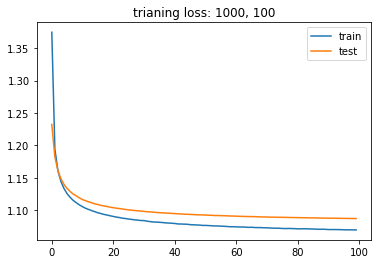

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss: 1000, 100')

Text(0.5, 1.0, 'trianing acc: auto encoder')

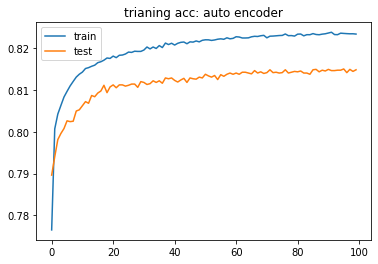

In [0]:
plt.plot([i for i in train_acc] , label='train')
plt.plot([i for i in test_acc ] , label ='test')
plt.legend()
plt.title('trianing acc: auto encoder')

In [0]:
test_dl = DataLoader(test_ds , batch_size=len(test_ds) , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(test_dl))
fs , ts = fs.to(device) , ts.to(device)

output = net2(encoder.encode(fs))
mx , argmx = torch.max(output, dim=1)


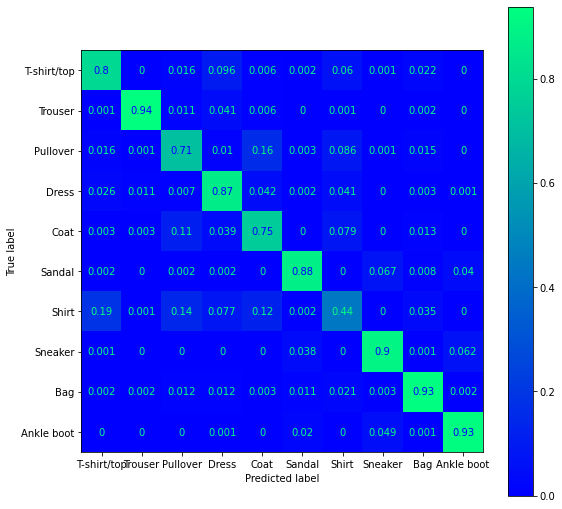

In [0]:
plt_conf_mat(ts.to('cpu'), argmx.to('cpu'), fmnist_test.classes)

In [0]:
accuracy_score(ts.to('cpu'), argmx.to('cpu'))

0.8134

# PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=200 , whiten=True)
train_dl = DataLoader(train_ds , batch_size=len(train_ds) , shuffle= False , num_workers = 1)
fs , ts = next(iter(train_dl))
pca.fit(fs)
pca

In [0]:
net3 = MLP0().to(device)

In [0]:
train_ds = FMNIST_DS(fmnist_train)
test_ds  = FMNIST_DS(fmnist_test)
batch_size = 256
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 10)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 10)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net3.parameters(),lr=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [0]:
def train_step(model, train_dl, criterion, optimizer, encoder):
    total_loss = 0.0
    total_correct = 0
    
    # for i, (train_inputs, train_labels) in tqdm_notebook(enumerate(train_dl), 
    #                                                      desc='Training', 
    #                                                      total=len(train_dl)):
    for i, (train_inputs, train_labels) in enumerate(train_dl):
        # move to device
        train_inputs = encoder.transform(train_inputs)
        train_inputs = torch.tensor(train_inputs, dtype=torch.float)
        train_inputs , train_labels = train_inputs.to(device) , train_labels.to(device)

        optimizer.zero_grad()
        output = model(train_inputs)
        loss = criterion(output, train_labels)
        loss.backward()     
        optimizer.step()
        total_loss += loss.item()
        with torch.no_grad():
            mx , argmx = torch.max(output, dim=1)
            total_correct += torch.sum(argmx == train_labels).item()/len(argmx)

    return total_loss/len(train_dl), total_correct/len(train_dl)


def validate_step(model, valid_dl, criterion, encoder):
    total_loss = 0.0
    total_correct = 0
    with torch.no_grad():
        # for i, (test_inputs, test_labels) in tqdm_notebook(enumerate(valid_dl), 
        #                                                 desc='Validation', 
        #                                                 total=len(valid_dl)):
        for i, (test_inputs, test_labels) in enumerate(valid_dl):
            # move to device
            test_inputs = encoder.transform(test_inputs)
            test_inputs = torch.tensor(test_inputs , dtype=torch.float)
            test_inputs , test_labels = test_inputs.to(device) , test_labels.to(device)
            output = model(test_inputs)
            loss = criterion(output, test_labels)
            total_loss += loss.item()

            mx , argmx = torch.max(output, dim=1)
            total_correct += torch.sum(argmx == test_labels).item()/len(argmx)

    return total_loss/len(test_dl), total_correct/len(test_dl)


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler, encoder, num_epochs, train_loss, test_loss, train_acc, test_acc):
    
    best_wts = None
    best_loss = float('inf')

    for epoch in range(num_epochs):

        ## perform one epoch of training and validation
        trn_loss, trn_acc = train_step(model, train_dl, criterion, optimizer, encoder)
        val_loss, val_acc = validate_step(model, valid_dl, criterion, encoder)
        scheduler.step()

        train_loss += [trn_loss]
        test_loss  += [val_loss]
        train_acc  += [trn_acc ]
        test_acc   += [val_acc ]

        # save weights
        if val_loss < best_loss:
            best_loss = val_loss
            best_wts = model.state_dict().copy()
            
# #             torch.save(best_wts, 'models/lstm-{}-{}-{}-{}-{}-{}-{:.5f}.pth'.format(
# #                 epoch, max_len, min_count, model.embed_size, model.hidden_size, model.num_layers, best_acc))

        print(f'[Epoch:{epoch+1}/{num_epochs}] Training Loss: %.4f| Testing Loss: %.4f| Training ACC: %.4f| Testing ACC: %.4f|'
              % (trn_loss* 10000, val_loss* 10000 , trn_acc*100, val_acc*100))

    model.load_state_dict(best_wts)
    return train_loss, test_loss, train_acc, test_acc

In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(net3, train_dl, test_dl, criterion, optimizer, scheduler, pca, 30, train_loss, test_loss, train_acc, test_acc)

[Epoch:1/30] Training Loss: 10215.1528| Testing Loss: 10551.8138| Training ACC: 84.8659| Testing ACC: 83.4100|
[Epoch:2/30] Training Loss: 10210.9589| Testing Loss: 10550.1485| Training ACC: 84.8864| Testing ACC: 83.4400|
[Epoch:3/30] Training Loss: 10205.7810| Testing Loss: 10550.1449| Training ACC: 84.9030| Testing ACC: 83.4700|
[Epoch:4/30] Training Loss: 10203.3111| Testing Loss: 10549.5727| Training ACC: 84.9197| Testing ACC: 83.5200|
[Epoch:5/30] Training Loss: 10201.9908| Testing Loss: 10548.6858| Training ACC: 84.9379| Testing ACC: 83.4600|
[Epoch:6/30] Training Loss: 10200.6868| Testing Loss: 10549.2282| Training ACC: 84.9490| Testing ACC: 83.4200|
[Epoch:7/30] Training Loss: 10198.7619| Testing Loss: 10548.6286| Training ACC: 84.9169| Testing ACC: 83.4300|
[Epoch:8/30] Training Loss: 10197.3061| Testing Loss: 10548.4915| Training ACC: 84.9396| Testing ACC: 83.3900|
[Epoch:9/30] Training Loss: 10195.9494| Testing Loss: 10548.4891| Training ACC: 84.9501| Testing ACC: 83.3800|
[

Text(0.5, 1.0, 'trianing loss: PCA')

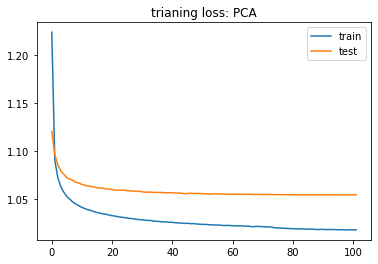

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss: PCA')

Text(0.5, 1.0, 'trianing acc: PCA')

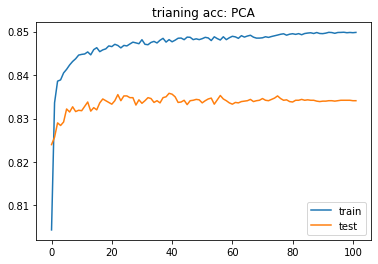

In [0]:
plt.plot([i for i in train_acc] , label='train')
plt.plot([i for i in test_acc ] , label ='test')
plt.legend()
plt.title('trianing acc: PCA')

In [0]:
test_dl = DataLoader(test_ds , batch_size=len(test_ds) , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(test_dl))
fs = pca.transform(fs)
fs = torch.tensor(fs, dtype=torch.float)
fs , ts = fs.to(device) , ts.to(device)

output = net3(fs)
mx , argmx = torch.max(output, dim=1)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f6f6b06f2e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


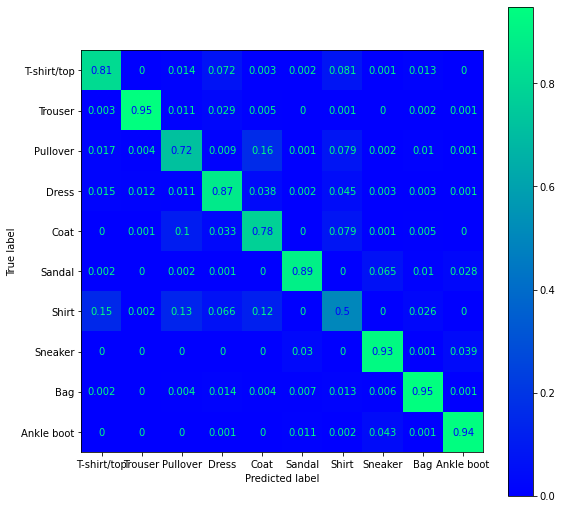

In [0]:
plt_conf_mat(ts.to('cpu'), argmx.to('cpu'), fmnist_test.classes)

In [0]:
accuracy_score(ts.to('cpu'), argmx.to('cpu'))

0.8341

# RBM

In [0]:
train_ds = ENCODE_DS(fmnist_train)
test_ds  = ENCODE_DS(fmnist_test)

In [0]:
class RBM(nn.Module):
    def __init__(self, input_dim = 784, hidden = 500):
        super().__init__()
        self.n = input_dim
        self.hidden = hidden

        # encode
        self.fc1  = nn.Linear(self.n, self.hidden)
        self.act1 = nn.Tanh()

        #decode
        self.fc2  = nn.Linear(self.hidden, self.n)
        self.act2 = nn.Tanh()

    def encode(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        return out

    def decode(self, x):
        out = self.fc2(x)
        out = self.act2(out)
        return out


    def forward(self, x):
        #encode
        out = self.encode(x)
        #decode
        out = self.decode(out)
        return out

In [0]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True,   num_workers = 8) 
test_dl  = DataLoader(test_ds , batch_size=256, shuffle= False, num_workers = 8)

In [0]:
RBM1 = RBM(784, 500).to(device)

In [0]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(RBM1.parameters(),lr=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [0]:
def plt_conf_mat(y_true , y_pred, labels, normalize = 'true'  , include_values = True, 
                 xticks_rotation='horizontal',
                 values_format=None,
                 cmap='winter'):
    plt.figure(figsize=[9, 9])
    ax = plt.subplot(1, 1, 1)
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

In [0]:
def train_step(model, train_dl, criterion, optimizer):
    total_loss = 0.0
    total_correct = 0
    
    # for i, (train_inputs, train_labels) in tqdm_notebook(enumerate(train_dl), 
    #                                                      desc='Training', 
    #                                                      total=len(train_dl)):
    for i, (train_inputs, train_labels) in enumerate(train_dl):
        # move to device
        train_inputs , train_labels = train_inputs.to(device) , train_labels.to(device)

        optimizer.zero_grad()
        output = model(train_inputs)
        loss = criterion(output, train_labels)
        loss.backward()     
        optimizer.step()
        total_loss += loss.item()
        # with torch.no_grad():
        #     mx , argmx = torch.max(output, dim=1)
        #     total_correct += torch.sum(argmx == train_labels).item()/len(argmx)

    return total_loss/len(train_dl), total_correct/len(train_dl)


def validate_step(model, valid_dl, criterion):
    total_loss = 0.0
    total_correct = 0
    with torch.no_grad():
        # for i, (test_inputs, test_labels) in tqdm_notebook(enumerate(valid_dl), 
        #                                                 desc='Validation', 
        #                                                 total=len(valid_dl)):
        for i, (test_inputs, test_labels) in enumerate(valid_dl):
            # move to device
            test_inputs , test_labels = test_inputs.to(device) , test_labels.to(device)

            output = model(test_inputs)
            loss = criterion(output, test_labels)
            total_loss += loss.item()

            # mx , argmx = torch.max(output, dim=1)
            # total_correct += torch.sum(argmx == test_labels).item()/len(argmx)

    return total_loss/len(test_dl), total_correct/len(test_dl)


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs, train_loss, test_loss, train_acc, test_acc):
    
    best_wts = None
    best_loss = float('inf')

    for epoch in range(num_epochs):

        ## perform one epoch of training and validation
        trn_loss, trn_acc = train_step(model, train_dl, criterion, optimizer)
        val_loss, val_acc = validate_step(model, valid_dl, criterion)
        scheduler.step()

        train_loss += [trn_loss]
        test_loss  += [val_loss]
        train_acc  += [trn_acc ]
        test_acc   += [val_acc ]

        # save weights
        if val_loss < best_loss:
            best_loss = val_loss
            best_wts = model.state_dict().copy()
            
# #             torch.save(best_wts, 'models/lstm-{}-{}-{}-{}-{}-{}-{:.5f}.pth'.format(
# #                 epoch, max_len, min_count, model.embed_size, model.hidden_size, model.num_layers, best_acc))

        print(f'[Epoch:{epoch+1}/{num_epochs}] Training Loss: %.4f| Testing Loss: %.4f| Training ACC: %.4f| Testing ACC: %.4f|'
              % (trn_loss* 10000, val_loss* 10000 , trn_acc*100, val_acc*100))

    model.load_state_dict(best_wts)
    return train_loss, test_loss, train_acc, test_acc

In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(RBM1, train_dl, test_dl, criterion, optimizer, scheduler, 50, train_loss, test_loss, train_acc, test_acc)

[Epoch:1/50] Training Loss: 132.5824| Testing Loss: 133.4821| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:2/50] Training Loss: 131.7721| Testing Loss: 132.6987| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:3/50] Training Loss: 130.9768| Testing Loss: 131.9229| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:4/50] Training Loss: 130.2654| Testing Loss: 131.1832| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:5/50] Training Loss: 129.4928| Testing Loss: 130.4636| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:6/50] Training Loss: 128.7513| Testing Loss: 129.7600| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:7/50] Training Loss: 128.0375| Testing Loss: 129.0665| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:8/50] Training Loss: 127.4121| Testing Loss: 128.4030| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:9/50] Training Loss: 126.7352| Testing Loss: 127.7705| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:10/50] Training Loss: 126.0985| Testing Loss: 12

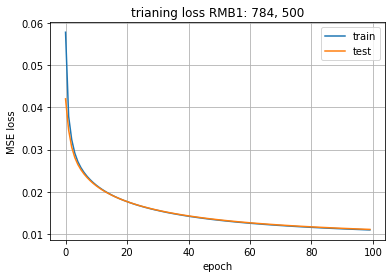

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss RMB1: 784, 500')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()

In [0]:
 torch.save(RBM1.state_dict().copy(), '/content/drive/My Drive/ut/NNDL/RBM1.pth')

In [0]:
class stackedRBM():
    def __init__(self, RBMs):
        self.RBMS = RBMs
        
    def encode(self, x):
        out = x
        for rbm in self.RBMS:
            out = rbm.encode(out)
        return out

    def decode(self, x):
        out = x
        for rbm in self.RBMS:
            out = rbm.decode(out)
        return out

    def forward(self, x):
        return self.decode(self.encode(x))

    def __call__(self, x):
        return self.forward(x)

In [0]:
def train_step(model, train_dl, criterion, optimizer, encoder):
    total_loss = 0.0
    total_correct = 0
    
    # for i, (train_inputs, train_labels) in tqdm_notebook(enumerate(train_dl), 
    #                                                      desc='Training', 
    #                                                      total=len(train_dl)):
    for i, (train_inputs, train_labels) in enumerate(train_dl):
        # move to device
        train_inputs , train_labels = train_inputs.to(device) , train_labels.to(device)
        train_inputs = encoder.encode(train_inputs)
        train_labels = encoder.encode(train_labels)

        optimizer.zero_grad()
        output = model(train_inputs)
        loss = criterion(output, train_labels)
        loss.backward()     
        optimizer.step()
        total_loss += loss.item()
        # with torch.no_grad():
        #     mx , argmx = torch.max(output, dim=1)
        #     total_correct += torch.sum(argmx == train_labels).item()/len(argmx)

    return total_loss/len(train_dl), total_correct/len(train_dl)


def validate_step(model, valid_dl, criterion, encoder):
    total_loss = 0.0
    total_correct = 0
    with torch.no_grad():
        # for i, (test_inputs, test_labels) in tqdm_notebook(enumerate(valid_dl), 
        #                                                 desc='Validation', 
        #                                                 total=len(valid_dl)):
        for i, (test_inputs, test_labels) in enumerate(valid_dl):
            # move to device
            test_inputs , test_labels = test_inputs.to(device) , test_labels.to(device)
            test_inputs = encoder.encode(test_inputs)
            test_labels = encoder.encode(test_labels)

            output = model(test_inputs)
            loss = criterion(output, test_labels)
            total_loss += loss.item()

            # mx , argmx = torch.max(output, dim=1)
            # total_correct += torch.sum(argmx == test_labels).item()/len(argmx)

    return total_loss/len(test_dl), total_correct/len(test_dl)


def train(model, encoder, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs, train_loss, test_loss, train_acc, test_acc):
    
    best_wts = None
    best_loss = float('inf')

    for epoch in range(num_epochs):

        ## perform one epoch of training and validation
        trn_loss, trn_acc = train_step(model, train_dl, criterion, optimizer, encoder)
        val_loss, val_acc = validate_step(model, valid_dl, criterion, encoder)
        scheduler.step()

        train_loss += [trn_loss]
        test_loss  += [val_loss]
        train_acc  += [trn_acc ]
        test_acc   += [val_acc ]

        # save weights
        if val_loss < best_loss:
            best_loss = val_loss
            best_wts = model.state_dict().copy()
            
# #             torch.save(best_wts, 'models/lstm-{}-{}-{}-{}-{}-{}-{:.5f}.pth'.format(
# #                 epoch, max_len, min_count, model.embed_size, model.hidden_size, model.num_layers, best_acc))

        print(f'[Epoch:{epoch+1}/{num_epochs}] Training Loss: %.4f| Testing Loss: %.4f| Training ACC: %.4f| Testing ACC: %.4f|'
              % (trn_loss* 10000, val_loss* 10000 , trn_acc*100, val_acc*100))

    model.load_state_dict(best_wts)
    return train_loss, test_loss, train_acc, test_acc

In [0]:
encoder = stackedRBM([RBM1])
RBM2 = RBM(500, 300).to(device)

In [0]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(RBM2.parameters(),lr=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(RBM2,encoder, train_dl, test_dl, criterion, optimizer, scheduler, 50, train_loss, test_loss, train_acc, test_acc)

[Epoch:1/50] Training Loss: 33.7430| Testing Loss: 34.0284| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:2/50] Training Loss: 33.5929| Testing Loss: 33.8836| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:3/50] Training Loss: 33.4536| Testing Loss: 33.7420| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:4/50] Training Loss: 33.3123| Testing Loss: 33.6034| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:5/50] Training Loss: 33.1731| Testing Loss: 33.4681| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:6/50] Training Loss: 33.0422| Testing Loss: 33.3355| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:7/50] Training Loss: 32.9048| Testing Loss: 33.2063| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:8/50] Training Loss: 32.7840| Testing Loss: 33.0799| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:9/50] Training Loss: 32.6456| Testing Loss: 32.9561| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:10/50] Training Loss: 32.5192| Testing Loss: 32.8347| Training ACC

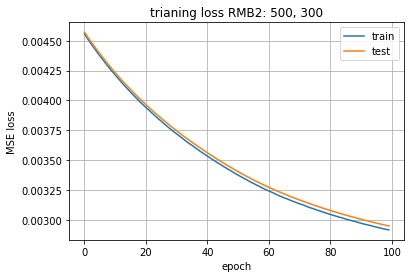

In [0]:
plt.plot([i for i in train_loss][50:] , label='train')
plt.plot([i for i in test_loss ][50:] , label ='test')
plt.legend()
plt.title('trianing loss RMB2: 500, 300')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()

In [0]:
#  torch.save(RBM2.state_dict().copy(), '/content/drive/My Drive/ut/NNDL/RBM2.pth')

In [0]:
encoder = stackedRBM([RBM1, RBM2])
RBM3 = RBM(300, 200).to(device)

In [0]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(RBM3.parameters(),lr=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(RBM3,encoder, train_dl, test_dl, criterion, optimizer, scheduler, 100, train_loss, test_loss, train_acc, test_acc)

[Epoch:1/100] Training Loss: 534.0623| Testing Loss: 375.0516| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:2/100] Training Loss: 307.3522| Testing Loss: 257.4380| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:3/100] Training Loss: 226.1966| Testing Loss: 201.0855| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:4/100] Training Loss: 182.2878| Testing Loss: 166.7760| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:5/100] Training Loss: 153.7702| Testing Loss: 142.9997| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:6/100] Training Loss: 133.1547| Testing Loss: 125.0844| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:7/100] Training Loss: 117.2549| Testing Loss: 110.8994| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:8/100] Training Loss: 104.5281| Testing Loss: 99.3207| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:9/100] Training Loss: 94.0237| Testing Loss: 89.7179| Training ACC: 0.0000| Testing ACC: 0.0000|
[Epoch:10/100] Training Loss: 85.2527| Testing Lo

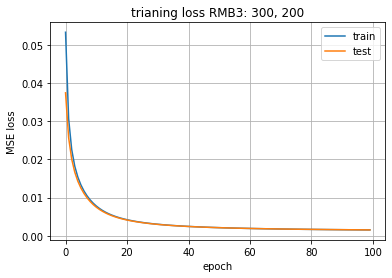

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss RMB3: 300, 200')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()

In [0]:
#  torch.save(RBM3.state_dict().copy(), '/content/drive/My Drive/ut/NNDL/RBM3.pth')

In [0]:
encoder = stackedRBM([RBM1, RBM2, RBM3])

In [0]:
net2 = MLP0().to(device)

In [0]:
train_ds = FMNIST_DS(fmnist_train)
test_ds  = FMNIST_DS(fmnist_test)
batch_size = 256
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 10)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 10)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net2.parameters(),lr=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [0]:
def train_step(model, train_dl, criterion, optimizer, encoder):
    total_loss = 0.0
    total_correct = 0
    
    # for i, (train_inputs, train_labels) in tqdm_notebook(enumerate(train_dl), 
    #                                                      desc='Training', 
    #                                                      total=len(train_dl)):
    for i, (train_inputs, train_labels) in enumerate(train_dl):
        # move to device
        train_inputs , train_labels = train_inputs.to(device) , train_labels.to(device)

        optimizer.zero_grad()
        train_inputs = encoder.encode(train_inputs)
        output = model(train_inputs)
        loss = criterion(output, train_labels)
        loss.backward()     
        optimizer.step()
        total_loss += loss.item()
        with torch.no_grad():
            mx , argmx = torch.max(output, dim=1)
            total_correct += torch.sum(argmx == train_labels).item()/len(argmx)

    return total_loss/len(train_dl), total_correct/len(train_dl)


def validate_step(model, valid_dl, criterion, encoder):
    total_loss = 0.0
    total_correct = 0
    with torch.no_grad():
        # for i, (test_inputs, test_labels) in tqdm_notebook(enumerate(valid_dl), 
        #                                                 desc='Validation', 
        #                                                 total=len(valid_dl)):
        for i, (test_inputs, test_labels) in enumerate(valid_dl):
            # move to device
            test_inputs , test_labels = test_inputs.to(device) , test_labels.to(device)
            test_inputs = encoder.encode(test_inputs)
            output = model(test_inputs)
            loss = criterion(output, test_labels)
            total_loss += loss.item()

            mx , argmx = torch.max(output, dim=1)
            total_correct += torch.sum(argmx == test_labels).item()/len(argmx)

    return total_loss/len(test_dl), total_correct/len(test_dl)


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler, encoder, num_epochs, train_loss, test_loss, train_acc, test_acc):
    
    best_wts = None
    best_loss = float('inf')

    for epoch in range(num_epochs):

        ## perform one epoch of training and validation
        trn_loss, trn_acc = train_step(model, train_dl, criterion, optimizer, encoder)
        val_loss, val_acc = validate_step(model, valid_dl, criterion, encoder)
        scheduler.step()

        train_loss += [trn_loss]
        test_loss  += [val_loss]
        train_acc  += [trn_acc ]
        test_acc   += [val_acc ]

        # save weights
        if val_loss < best_loss:
            best_loss = val_loss
            best_wts = model.state_dict().copy()
            
# #             torch.save(best_wts, 'models/lstm-{}-{}-{}-{}-{}-{}-{:.5f}.pth'.format(
# #                 epoch, max_len, min_count, model.embed_size, model.hidden_size, model.num_layers, best_acc))

        print(f'[Epoch:{epoch+1}/{num_epochs}] Training Loss: %.4f| Testing Loss: %.4f| Training ACC: %.4f| Testing ACC: %.4f|'
              % (trn_loss* 10000, val_loss* 10000 , trn_acc*100, val_acc*100))

    model.load_state_dict(best_wts)
    return train_loss, test_loss, train_acc, test_acc

In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(net2, train_dl, test_dl, criterion, optimizer, scheduler, encoder, 100, train_loss, test_loss, train_acc, test_acc)

[Epoch:1/100] Training Loss: 10568.2201| Testing Loss: 10766.7170| Training ACC: 82.6707| Testing ACC: 81.7188|
[Epoch:2/100] Training Loss: 10570.0126| Testing Loss: 10766.2668| Training ACC: 82.6357| Testing ACC: 81.7480|
[Epoch:3/100] Training Loss: 10566.3621| Testing Loss: 10766.0594| Training ACC: 82.6568| Testing ACC: 81.7578|
[Epoch:4/100] Training Loss: 10565.0638| Testing Loss: 10765.8508| Training ACC: 82.6468| Testing ACC: 81.7578|
[Epoch:5/100] Training Loss: 10567.6041| Testing Loss: 10765.7301| Training ACC: 82.6463| Testing ACC: 81.7188|
[Epoch:6/100] Training Loss: 10565.8253| Testing Loss: 10765.6514| Training ACC: 82.6629| Testing ACC: 81.7285|
[Epoch:7/100] Training Loss: 10565.8393| Testing Loss: 10765.5621| Training ACC: 82.6734| Testing ACC: 81.7383|
[Epoch:8/100] Training Loss: 10567.9461| Testing Loss: 10765.4991| Training ACC: 82.6502| Testing ACC: 81.7285|
[Epoch:9/100] Training Loss: 10563.7192| Testing Loss: 10765.4407| Training ACC: 82.6773| Testing ACC: 8

Text(0.5, 1.0, 'trianing loss: 1000, 100')

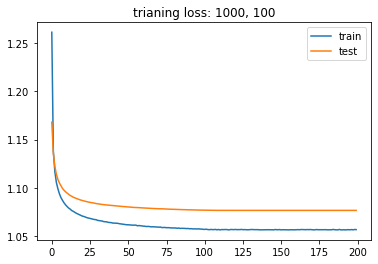

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss: 1000, 100')

Text(0.5, 1.0, 'trianing acc: auto encoder')

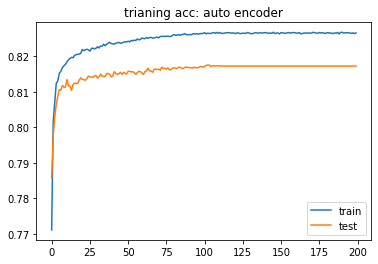

In [0]:
plt.plot([i for i in train_acc] , label='train')
plt.plot([i for i in test_acc ] , label ='test')
plt.legend()
plt.title('trianing acc: auto encoder')

In [0]:
test_dl = DataLoader(test_ds , batch_size=len(test_ds) , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(test_dl))
fs , ts = fs.to(device) , ts.to(device)

output = net2(encoder.encode(fs))
mx , argmx = torch.max(output, dim=1)


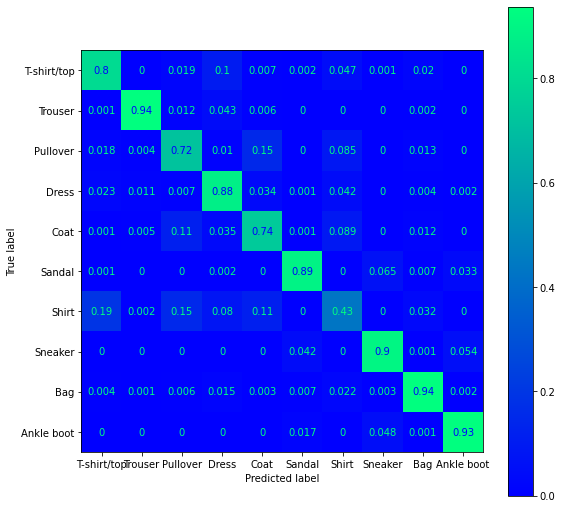

In [0]:
plt_conf_mat(ts.to('cpu'), argmx.to('cpu'), fmnist_test.classes)

In [0]:
accuracy_score(ts.to('cpu'), argmx.to('cpu'))

0.8174